## **Mô hình Softmax Regression**

## **Import các thư viện cần thiết**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## **Dữ liệu**

In [2]:
df = pd.read_csv("../../../data/data_processed/data_processed.csv")
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,4.0,0.0,4.0,2.0,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,2.0,0.0,5.0,2.0,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,2.0,0.0,6.0,2.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,4.0,0.0,5.0,0.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


## **Xây dựng Softmax Regression**

In [3]:
# Tách đặc trưng và nhãn
X = df.drop(columns=["NSP"]).values
# Nhãn: chuyển về 0, 1, 2
y = df["NSP"].values - 1 

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
C = len(np.unique(y))


In [4]:
def convert_labels(y, C):
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape=(C, len(y))).toarray()
    return Y

def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return e_Z / e_Z.sum(axis=0)

def softmax(Z):
    e_Z = np.exp(Z)
    return e_Z / e_Z.sum(axis=0)

def softmax_regression(X, y, W_init, eta=0.05, tol=1e-4, max_count=10000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 1500
    while count < max_count:
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta * xi.dot((yi - ai).T)
            count += 1
            if count % check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

def pred(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis=0)

In [5]:
def evaluate_model(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return acc, cr, cm


## **Triển khai Softmax Regression với nhiều tỷ lệ train/validation: 4:1; 7:3; 6:4**

### **Giảm trước chia sau**

In [6]:
def softmax_pipeline(X, y, train_ratios=[0.8, 0.7, 0.6], use_pca=False, use_lda=False, n_components=None, lam=0):
    results = []
    
    ratio_labels = {
        0.8: "4:1",
        0.7: "7:3", 
        0.6: "6:4"
    }

    for train_ratio in train_ratios:
        method = "gốc"
        X_temp = X.copy()
        
        # Áp dụng PCA/LDA trước khi chia tập
        if use_pca:
            method = "PCA"
            pca = PCA(n_components=n_components)
            X_temp = pca.fit_transform(X_temp)
        elif use_lda:
            method = "LDA"
            lda = LDA(n_components=min(n_components, len(np.unique(y))-1))
            X_temp = lda.fit_transform(X_temp, y)

        # Chia tập train/test
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y, 
            train_size=train_ratio, 
            stratify=y,
            random_state=42
        )
        
        # Thêm bias term sau khi chia
        X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
        X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
        
        # Chuyển đổi sang dạng cột
        X_train_T = X_train.T
        X_val_T = X_val.T
        
        # Khởi tạo trọng số
        d = X_train_T.shape[0]
        C = len(np.unique(y))
        W_init = np.random.randn(d, C)
        
        # Huấn luyện mô hình
        W = softmax_regression(X_train_T, y_train, W_init)[-1]
        
        # Dự đoán và đánh giá
        y_pred = pred(W, X_val_T)
        acc, cr, cm = evaluate_model(y_val, y_pred)
        
        # Lưu kết quả
        ratio_str = ratio_labels.get(train_ratio, f"{train_ratio*100:.0f}:{(1-train_ratio)*100:.0f}")
        
        print(f"\nMô hình Softmax Regression với dữ liệu {method}:")
        print(f"Tỷ lệ {ratio_str}")
        print(f"Accuracy: {acc:.4f}")
        print("Classification Report:")
        print(cr)
        
        results.append({
            'method': method,
            'train_ratio': ratio_str,
            'accuracy': acc,
            'report': cr,
            'confusion_matrix': cm
        })
    
    return results

In [7]:
print(X_scaled.shape)  # Kiểm tra kích thước của X
print(y.shape)         # Kiểm tra kích thước của y


(2126, 21)
(2126,)


In [8]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6])


Mô hình Softmax Regression với dữ liệu gốc:
Tỷ lệ 4:1
Accuracy: 0.8756
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94       332
         1.0       0.57      0.86      0.69        59
         2.0       0.82      0.51      0.63        35

    accuracy                           0.88       426
   macro avg       0.79      0.76      0.75       426
weighted avg       0.90      0.88      0.88       426


Mô hình Softmax Regression với dữ liệu gốc:
Tỷ lệ 7:3
Accuracy: 0.8777
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       497
         1.0       0.57      0.69      0.63        88
         2.0       0.88      0.57      0.69        53

    accuracy                           0.88       638
   macro avg       0.80      0.73      0.75       638
weighted avg       0.89      0.88      0.88       638


Mô hình Softmax Regression với dữ liệu gốc:
Tỷ 

In [9]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.7])


Mô hình Softmax Regression với dữ liệu gốc:
Tỷ lệ 7:3
Accuracy: 0.8887
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95       497
         1.0       0.61      0.70      0.66        88
         2.0       0.89      0.58      0.70        53

    accuracy                           0.89       638
   macro avg       0.81      0.75      0.77       638
weighted avg       0.89      0.89      0.89       638



Kết quả dữ liệu với tỉ lệ 7:3


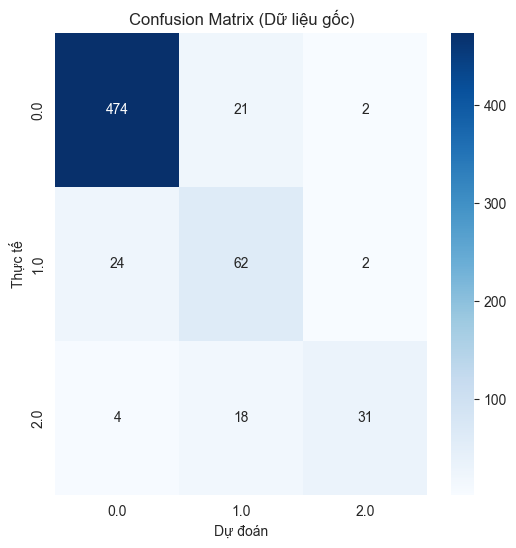

In [10]:
for res in results:
    if res['method'] == 'gốc' and res['train_ratio'] == '7:3':
        print("Kết quả dữ liệu với tỉ lệ 7:3")
        # Trích xuất confusion matrix
        conf_matrix = res['confusion_matrix']

# Vẽ ma trận confusion
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
        xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (Dữ liệu gốc)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

In [11]:
print(conf_matrix)

[[474  21   2]
 [ 24  62   2]
 [  4  18  31]]


#### **Thực hiện với dữ liệu đã giảm chiều bằng PCA**

In [12]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6], use_pca=True, n_components=12)


Mô hình Softmax Regression với dữ liệu PCA:
Tỷ lệ 4:1
Accuracy: 0.8615
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93       332
         1.0       0.54      0.75      0.62        59
         2.0       0.79      0.54      0.64        35

    accuracy                           0.86       426
   macro avg       0.76      0.73      0.73       426
weighted avg       0.88      0.86      0.87       426


Mô hình Softmax Regression với dữ liệu PCA:
Tỷ lệ 7:3
Accuracy: 0.8746
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       497
         1.0       0.58      0.65      0.61        88
         2.0       0.83      0.55      0.66        53

    accuracy                           0.87       638
   macro avg       0.78      0.71      0.74       638
weighted avg       0.88      0.87      0.87       638


Mô hình Softmax Regression với dữ liệu PCA:
Tỷ 

#### **Thực hiện với dữ liệu đã giảm chiều bằng LDA**

In [13]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6], use_lda=True, n_components=2)


Mô hình Softmax Regression với dữ liệu LDA:
Tỷ lệ 4:1
Accuracy: 0.8897
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94       332
         1.0       0.64      0.75      0.69        59
         2.0       0.76      0.74      0.75        35

    accuracy                           0.89       426
   macro avg       0.79      0.81      0.79       426
weighted avg       0.90      0.89      0.89       426


Mô hình Softmax Regression với dữ liệu LDA:
Tỷ lệ 7:3
Accuracy: 0.8840
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       497
         1.0       0.61      0.65      0.63        88
         2.0       0.86      0.57      0.68        53

    accuracy                           0.88       638
   macro avg       0.80      0.72      0.75       638
weighted avg       0.88      0.88      0.88       638


Mô hình Softmax Regression với dữ liệu LDA:
Tỷ 

### **Chia trước giảm sau**

In [14]:
def softmax_pipeline(X, y, train_ratios=[0.8, 0.7, 0.6], use_pca=False, use_lda=False, n_components=None, lam=0):
    results = []

    ratio_labels = {
        0.8: "4:1",
        0.7: "7:3",
        0.6: "6:4"
    }

    for train_ratio in train_ratios:
        method = "gốc"
        
        # 1. Chia dữ liệu train/test trước
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, train_size=train_ratio, stratify=y, random_state=42)

        # 2. Giảm chiều (nếu có)
        if use_pca:
            method = "PCA"
            pca = PCA(n_components=n_components)
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val)
        elif use_lda:
            method = "LDA"
            lda = LDA(n_components=min(n_components, len(np.unique(y))-1))
            X_train = lda.fit_transform(X_train, y_train)
            X_val = lda.transform(X_val)

        # 3. Thêm bias term (cột 1) vào CUỐI CÙNG sau khi đã xử lý dữ liệu
        X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
        X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])

        # Chuyển đổi sang dạng cột để tính toán
        X_train_T = X_train.T
        X_val_T = X_val.T
        d = X_train_T.shape[0]  # Đã bao gồm cả bias term

        C = len(np.unique(y))
        W_init = np.random.randn(d, C)
        
        # Huấn luyện mô hình (truyền thêm lam nếu cần)
        W = softmax_regression(X_train_T, y_train, W_init)[-1]
        y_pred = pred(W, X_val_T)

        # Đánh giá
        acc, cr, cm = evaluate_model(y_val, y_pred)

        ratio_str = ratio_labels.get(train_ratio, f"{train_ratio*100:.0f}:{(1-train_ratio)*100:.0f}")

        print("\nMô hình Softmax Regression với dữ liệu", method + ":")
        print(f"Tỷ lệ {ratio_str}")
        print(f"Accuracy: {acc:.4f}")
        print("Classification Report:")
        print(cr)

        results.append({
            'method': method,
            'train_ratio': ratio_str,
            'accuracy': acc,
            'report': cr,
            'confusion_matrix': cm
        })

    return results

#### **Thực hiện trên tập dữ liệu giảm chiều bằng PCA**

In [15]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6], use_pca=True, n_components=12)


Mô hình Softmax Regression với dữ liệu PCA:
Tỷ lệ 4:1
Accuracy: 0.8897
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       332
         1.0       0.68      0.54      0.60        59
         2.0       0.79      0.74      0.76        35

    accuracy                           0.89       426
   macro avg       0.80      0.75      0.77       426
weighted avg       0.88      0.89      0.88       426


Mô hình Softmax Regression với dữ liệu PCA:
Tỷ lệ 7:3
Accuracy: 0.8793
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94       497
         1.0       0.66      0.53      0.59        88
         2.0       0.81      0.66      0.73        53

    accuracy                           0.88       638
   macro avg       0.80      0.72      0.75       638
weighted avg       0.87      0.88      0.87       638


Mô hình Softmax Regression với dữ liệu PCA:
Tỷ 

In [16]:
# Tìm mô hình có accuracy cao nhất
best_model = max(results, key=lambda x: x['accuracy'])

# In ra kết quả của mô hình tốt nhất
print(f"Mô hình tốt nhất: {best_model['method']} với tỷ lệ huấn luyện {best_model['train_ratio']}")
print(f"Accuracy: {best_model['accuracy']}")


Mô hình tốt nhất: PCA với tỷ lệ huấn luyện 4:1
Accuracy: 0.8896713615023474


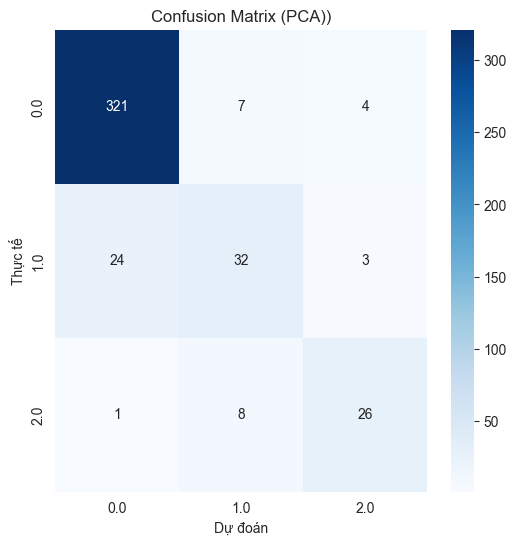

In [17]:
conf_matrix_best = best_model['confusion_matrix']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (PCA))")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

#### **Thực hiện với dữ liệu đã giảm chiều bằng LDA**

In [18]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6], use_lda=True, n_components=2)


Mô hình Softmax Regression với dữ liệu LDA:
Tỷ lệ 4:1
Accuracy: 0.8897
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       332
         1.0       0.67      0.58      0.62        59
         2.0       0.70      0.74      0.72        35

    accuracy                           0.89       426
   macro avg       0.77      0.76      0.76       426
weighted avg       0.89      0.89      0.89       426


Mô hình Softmax Regression với dữ liệu LDA:
Tỷ lệ 7:3
Accuracy: 0.8824
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       497
         1.0       0.64      0.53      0.58        88
         2.0       0.76      0.74      0.75        53

    accuracy                           0.88       638
   macro avg       0.78      0.74      0.76       638
weighted avg       0.88      0.88      0.88       638


Mô hình Softmax Regression với dữ liệu LDA:
Tỷ 

In [19]:
# Tìm mô hình có accuracy cao nhất
best_model = max(results, key=lambda x: x['accuracy'])

# In ra kết quả của mô hình tốt nhất
print(f"Mô hình tốt nhất: {best_model['method']} với tỷ lệ huấn luyện {best_model['train_ratio']}")
print(f"Accuracy: {best_model['accuracy']}")


Mô hình tốt nhất: LDA với tỷ lệ huấn luyện 6:4
Accuracy: 0.8930669800235017


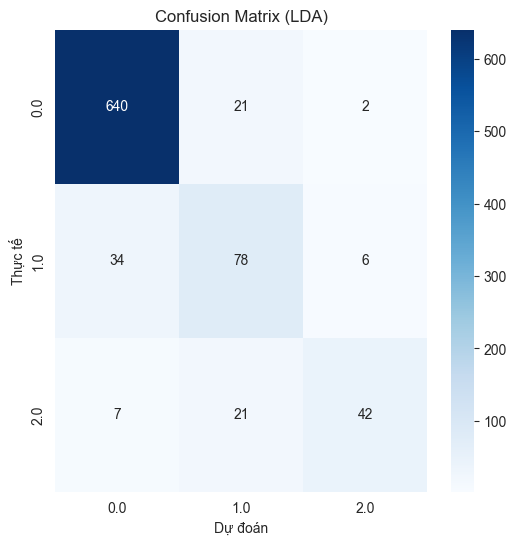

In [20]:
conf_matrix_best = best_model['confusion_matrix']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (LDA)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

# Đánh giá hai mô hình KNN và Softmax Regression tốt nhất

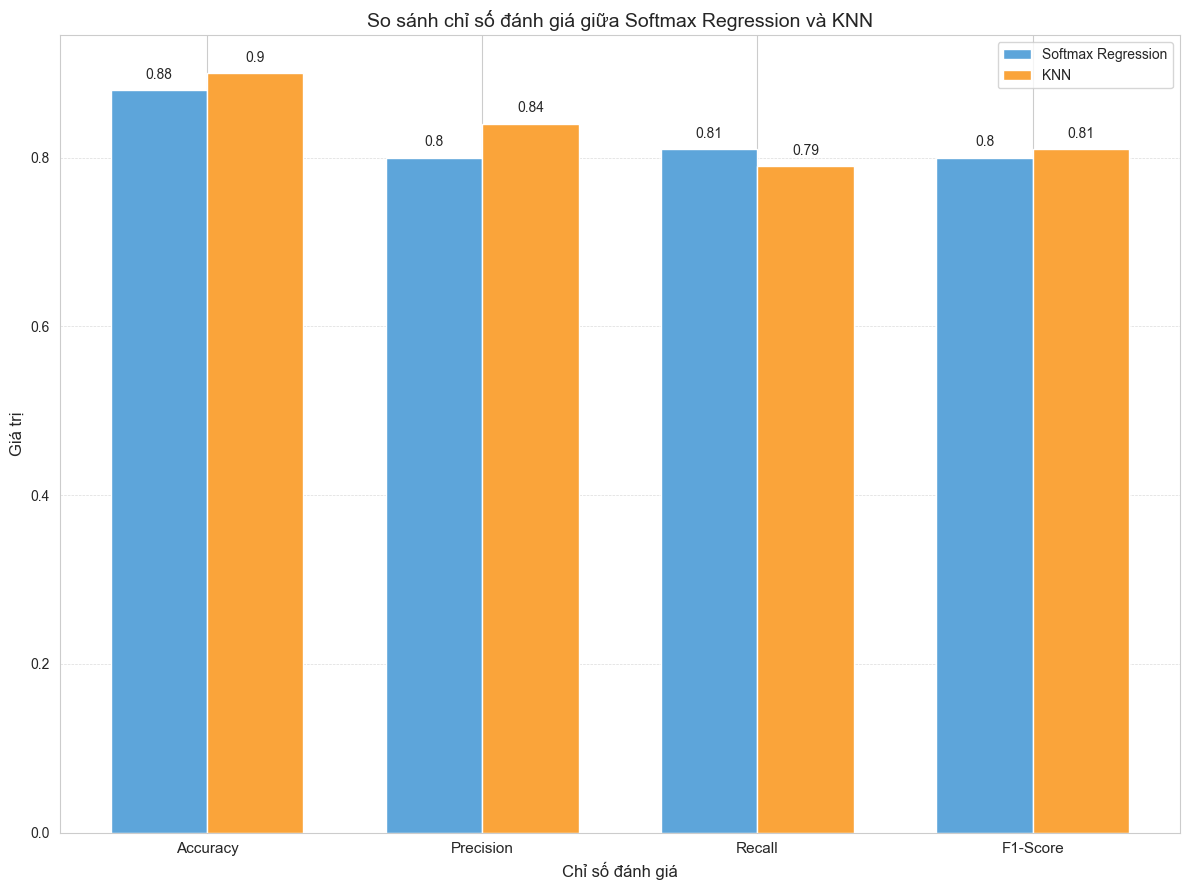

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Dữ liệu cho mô hình
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
softmax_values = [0.88, 0.80, 0.81, 0.80]
knn_values = [0.90, 0.84, 0.79, 0.81]

# Vị trí các cột
x = np.arange(len(metrics))  
width = 0.35  

colors = ['#5DA5DA', '#FAA43A']
# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(12, 9))

bars1 = ax.bar(x - width/2, softmax_values, width, label='Softmax Regression', color=colors[0])
bars2 = ax.bar(x + width/2, knn_values, width, label='KNN', color=colors[1])

# Nhãn và tiêu đề
ax.set_xlabel('Chỉ số đánh giá', fontsize=12)
ax.set_ylabel('Giá trị', fontsize=12)
ax.set_title('So sánh chỉ số đánh giá giữa Softmax Regression và KNN', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend()

# Lưới nhẹ
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Thêm giá trị lên các cột
def add_values(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), 
                va='bottom', ha='center', fontsize=10)

add_values(bars1)
add_values(bars2)

plt.tight_layout()
plt.show()
